In [1]:
import pickle as cPickle
import gzip
#import random

import numpy as np
%pylab inline 
import matplotlib.pyplot as pl
#import pylab as pl # библиотека для построения графиков

Populating the interactive namespace from numpy and matplotlib


In [2]:
def load_data():
    '''
    traning_data - массив из 50000 тренировочных примеров, 
    0 - элемент содержит массив массивов бит изображений
    1 - соответствующий картинке номер
    validation_data и test_data аналогичные, но содержат 
    по 10000 значений
    '''
    f = gzip.open('./data/mnist.pkl.gz', 'rb')
    training_data, validation_data, test_data = cPickle.load(f,encoding='latin1')
    f.close()
    return (training_data, validation_data, test_data)

In [3]:
training, validation, test = load_data()

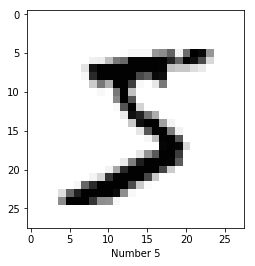

In [4]:
test = np.reshape(training[0][0],(28,28))
pl.imshow(test,cmap='Greys')
pl.xlabel(('Number %d' % training[1][0]))

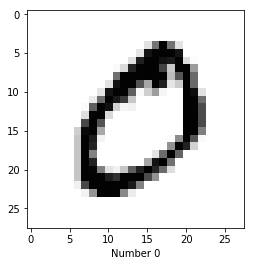

In [5]:
test = np.reshape(training[0][1],(28,28))
pl.imshow(test,cmap='Greys')
pl.xlabel(('Number %d' % training[1][1]))

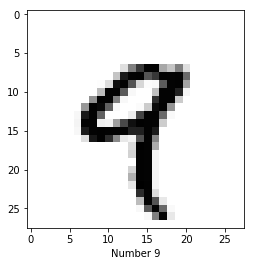

In [6]:
test = np.reshape(training[0][4],(28,28))
pl.imshow(test,cmap='Greys')
pl.xlabel(('Number %d' % training[1][4]))

In [7]:
def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

In [8]:
def load_data_wrapper():
    tr_d, va_d, te_d = load_data()
    training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
    training_results = [vectorized_result(y) for y in tr_d[1]]
    training_data = zip(training_inputs, training_results)
    validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
    validation_data = zip(validation_inputs, va_d[1])
    test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
    test_zipped = zip(test_inputs, te_d[1])
    return (training_data, validation_data,test_zipped)

In [9]:
def sigmoid(z):
    """Вычисление сигмоидальной функции"""
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    """Производная сигмоидальной функции"""
    return sigmoid(z)*(1-sigmoid(z))

In [10]:
class Network(object):

    def __init__(self, sizes):
        """sizez - список, содержащий число нейронов 
        на различных слоях сети. 
        К примеру, если size=[2, 3, 1], то будет создана 
        трехслойная сеть. С первым слоем из двух нейронов, вторым слоем 3
        И одним выходным нейроном. Веса генерируются случайным образом.
        Первый слой является входным, поэтому к нему не устанавливается 
        порог активации (bias)
        """
        self.num_layers = len(sizes) # число слоев
        self.sizes = sizes 
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, a):
        """Осуществляет прямое распространение сигнала
            через все слои
        """
        for b, w in zip(self.biases, self.weights): 
            a = sigmoid(np.dot(w, a)+b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, test_data=None):
        """
        Реализация стохастического градиентного спуска
        ``training_data`` это список пар ``(x, y)``,
        представляющих вход и желаемый выход
        ``epochs`` - число эпох обучения (сколько итераций 
        происходит при обучении)
        """
        if test_data: 
            n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            # Для всех итераций обучения (эпох)
            # перемешиваем данные, чтобы порядок в каждой эпохе
            # был разным
            random.shuffle(training_data)
            # разбиваем обучающую выборку на более мелкие участки
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            # для каждого участка
            for mini_batch in mini_batches:               
                # осуществляем градиентный спуск
                self.update_mini_batch(mini_batch, eta)
            
            if test_data:
                # если тестовые данные переданы, то на каждом шаге
                # запустим вычисление и оценим качество распознавания
                prop=self.evaluate(test_data)
                print ("Эпоха обучения {0}: {1} / {2} , {3}%".format(j, prop, n_test,prop*100/n_test))
            else:
                print("Обучение закончено".format(j))    
    
    def update_mini_batch(self, mini_batch, eta):
        """Обновляем веса и коэффициенты активации (biases),
        применяя градиентный спуск к каждой обучающей выборке (mini batch)
        используя обратное распространение ошибке.
        ``mini_batch`` список пар входа и выхода ``(x, y)``, а ``eta``
        коэффициент скорости обучения."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]
        
    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def evaluate(self, test_data):
        """Возвращаем количество тестовых результатов,
        для которых наша сеть нашла верный ответ 
        (наивысший уровень активации, поскольку у нас 
        на выходе массив в каждом из которыхможет присуствовать значение 
        от 0 до 1.
        """
        # как обычно используем генератор списков
        # каждую пару x,y забираем из тестовых данных
        # прогоняем в прямом направлении (веса у нас к
        # этому моменту настроены)
        # определяем индекс максимального элемента и записываем 
        # в список
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        # Перебираем все результаты
        # и суммируем число совпадений
        return sum(int(x == y) for (x, y) in test_results)

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        return (output_activations-y)


In [13]:
(training_data,validation_data,tst_data)=load_data_wrapper()
net = Network([784, 10, 10])
trd=list(training_data)
vd=list(validation_data)
td = list(tst_data)
net.SGD(trd, epochs=10, mini_batch_size=10, eta=3.0, test_data=td)

Эпоха обучения 0: 8677 / 10000 , 86.77%
Эпоха обучения 1: 8895 / 10000 , 88.95%
Эпоха обучения 2: 9003 / 10000 , 90.03%
Эпоха обучения 3: 9051 / 10000 , 90.51%
Эпоха обучения 4: 9037 / 10000 , 90.37%
Эпоха обучения 5: 9069 / 10000 , 90.69%
Эпоха обучения 6: 9084 / 10000 , 90.84%
Эпоха обучения 7: 9077 / 10000 , 90.77%
Эпоха обучения 8: 9090 / 10000 , 90.9%
Эпоха обучения 9: 9179 / 10000 , 91.79%


In [12]:
print(len(td))
tmp = [(np.argmax(td[1], y) for (x, y) in td)]
a=[x+1 for x in range(0,10)]
print(a)
x=[0,0.3,0]
y=[0,1,0]
print()
sum(a)

10000
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]



55